## Imports

In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from datasets import ExperimentRunner
import time



c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [2]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }



In [3]:
from dot_product import CPUDotProduct, CPUDotProductPositive, LoihiDotProductSimulationPositiveDBScale


In [4]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/day_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_right--day_left/gt.mat")

In [5]:
dot_cpu = CPUDotProduct(D1, D2)
dot_cpu_rslt = dot_cpu.run()

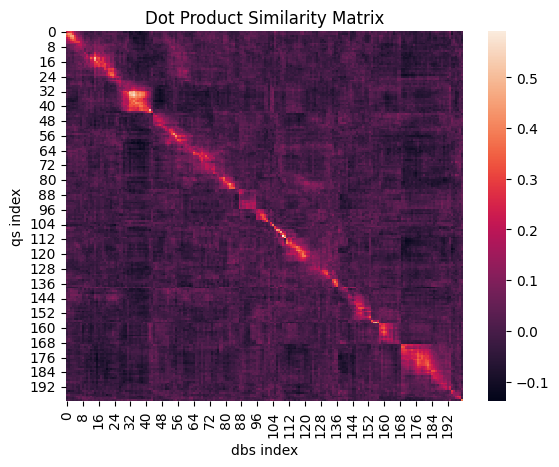

In [6]:
import seaborn as sns

ax = sns.heatmap(dot_cpu_rslt)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

In [21]:
# constant = 1/math.sqrt(2)
constant = 0
timesteps = 16
dbScale = 6*3


dot = LoihiDotProductSimulationPositiveDBScale(D1, D2, constant, timesteps=timesteps, dbScale=dbScale)


In [22]:
DD = dot.run(customTimesteps=10)

 22%|██▎       | 45/200 [00:08<00:29,  5.24it/s]


KeyboardInterrupt: 

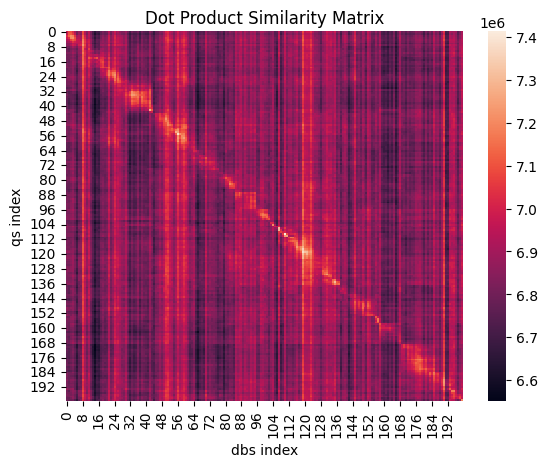

In [26]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

In [10]:
metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.799879964076551


In [11]:
0.79996320345498

0.79996320345498

In [12]:
cpu_query = dot_cpu.scaled_queryVectors
cpu_db = dot_cpu.scaled_dbVectors


In [ ]:
m_q = np.min(cpu_query[0])
M_q = np.max(cpu_query[0])
m_db = np.min(cpu_db)
M_db = np.max(cpu_db)

q_m = constant*(1 - m_q)
s_q = timesteps / ((M_q - m_q) * constant)
d_m = constant*(1 - m_db)
s_d = dbScale / ((M_db - m_db) * constant)

In [14]:
print(s_q, s_d, s_q*s_d)
print(q_m, d_m)
print(np.mean(D1), np.mean(D2))

214.93022354957495 141.788936700714 30474.72786194099
0.7422783522016984 0.774651903745946
-0.03988569681564513 0.020939381538614726


In [15]:
DD_real = DD.copy()
DD_scaled = DD.copy() / 2**4
for i in range(len(DD)):
    for j in range(len(DD[i])):
        DD_real[i][j] = DD_scaled[i][j] / (s_q*s_d) - d_m*np.sum(cpu_query[i]) - q_m*np.sum(cpu_db[j]) - d_m*q_m*len(cpu_query[i])
        # print(DD_scaled[i][j] / (s_q*s_d))

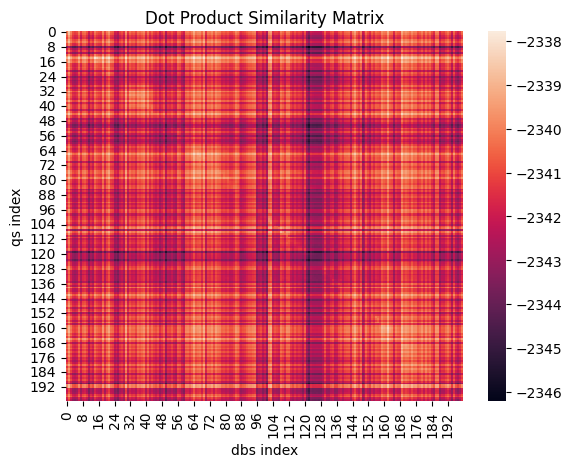

In [16]:
ax = sns.heatmap(DD_real)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

In [17]:
dot_cpu = CPUDotProduct(D1, D2)
dot_cpu_rslt = dot_cpu.run()

queryVector :
[[ 14.32834435  -7.13917255 -21.23714066 ...   2.71953917   5.70132065   7.65564537]
 [-18.59262657 -17.94606018  -2.64233184 ...  28.19717789  24.4493103  -17.085392  ]
 [-11.13034153  -1.70238364  16.3022728  ...   0.04498482  28.92576981 -19.57056808]
 ...
 [  3.36008501 -15.46534348 -15.10715103 ...  18.14228058  21.1836071   -6.53323174]
 [  0.8964777   24.92410469  27.12601471 ... -16.95738602 -21.95389557  22.61919022]
 [ 25.53693962  19.78870201 -13.04193401 ...  -5.96082497 -26.93701172  40.89674377]]
self.mu1 :
[ -6.00064927   0.34417251   0.3360098  ... -13.61052392  -1.63773068  -1.63262017]
queryVector_centered :
[[ 20.32899361  -7.48334506 -21.57315046 ...  16.33006309   7.33905132   9.28826554]
 [-12.59197731 -18.29023269  -2.97834164 ...  41.80770181  26.08704098 -15.45277183]
 [ -5.12969226  -2.04655615  15.966263   ...  13.65550874  30.56350048 -17.93794792]
 ...
 [  9.36073428 -15.80951599 -15.44316083 ...  31.7528045   22.82133778  -4.90061157]
 [  6.8

In [18]:
dot_cpu_rslt = dot_cpu_rslt.reshape(-1)

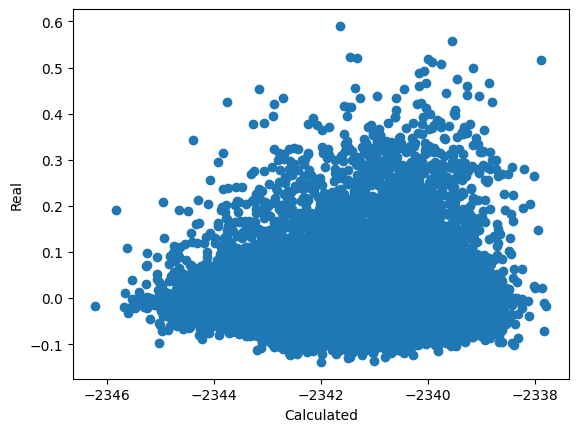

In [ ]:
dot_loihi = DD.reshape(-1)
dot_real = DD_real.reshape(-1)
plt.scatter(dot_real, dot_cpu_rslt)
plt.xlabel('Calculated')
plt.ylabel('Real')
plt.show()




## Theoretical Proof

In [5]:
# Generate random vectors and compare actual dot product vs derived formula
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

D = 1000  # Dimension of vectors
num_iterations = 1  # Number of iterations
c = 1  # Constant for augmentation
t = 10  # Timesteps parameter
d_s = 10  # Database scale parameter

In [6]:
from dot_product import LoihiExactDotProduct

In [7]:
def snn_dot_loihi(d_dash, q_dash):
    dot_loihi_exact = LoihiExactDotProduct(np.array([d_dash]), np.array([q_dash]), c, timesteps=t, dbScale=d_s)
    return dot_loihi_exact.run(customTimesteps=t-1)[0][0]


In [8]:
def snn_dot(q_dash, d_dash):
    # Make negative elements of q_dash zero
    print(f"Negative elements count: q_dash={np.sum(q_dash < 0)}, d_dash={np.sum(d_dash < 0)}")
    q_dash_clipped = np.maximum(q_dash, 0)
    d_dash_clipped = np.maximum(d_dash, 0)
    # Use the clipped version for the dot product calculation
    return np.dot(q_dash_clipped, d_dash_clipped)


In [9]:
# Arrays to store results
actual_dots = []
derived_dots = []

# Set random seed for reproducibility
np.random.seed(43)

# Loop through iterations with progress bar
for _ in tqdm(range(num_iterations)):
    # Generate random vectors
    q = np.random.randn(D)
    d = np.random.randn(D)
    
    # Normalize the vectors
    q = q / np.linalg.norm(q)
    d = d / np.linalg.norm(d)

    # Create a vector with all elements equal to 1
    ones = np.ones(D)
    
    # Calculate normalization constants
    k1 = np.linalg.norm(q + c*ones)
    k2 = np.linalg.norm(d + c*ones)
    
    # Calculate min and max values
    m_q = np.min((q + c*ones)/k1)
    M_q = np.max((q + c*ones)/k1)
    m_d = np.min((d + c*ones)/k2)
    M_d = np.max((d + c*ones)/k2)
    
    # Derived quantities
    a = t / (M_q - m_q)
    b = d_s / (M_d - m_d)
    
    # Calculate transformed vectors
    q_dash = ((q + c*ones) / k1 - m_q*ones) * a
    d_dash = ((d + c*ones) / k2 - m_d*ones) * b
    
    # Calculate actual dot product
    actual_dot = np.dot(q, d)
    
    # print(q_dash[0])
    snn_dot_value = snn_dot_loihi(d_dash, q_dash)
    # print(q_dash[0])
    # snn_dot_value = snn_dot(q_dash, d_dash)
    print(snn_dot_value)

    # Calculate derived dot product
    T1 = (k1*k2)/(a*b) * snn_dot_value
    T2 = (c - k2*m_d)*np.sum(q)
    T3 = (c - k1*m_q)*np.sum(d)
    T4 = (c - k2*m_d)*(c-k1*m_q)*D
    derived_dot = T1 -  T2 - T3 - T4
    
    print(f"T1: {T1}, T2: {T2}, T3: {T3}, T4: {T4}")
    
    # Store results
    actual_dots.append(actual_dot)
    derived_dots.append(derived_dot)


  0%|          | 0/1 [00:00<?, ?it/s]

transform_dbVectors :
[[ 6.33446252  5.40505692  6.65439118  6.07537512  4.82867022  8.79845136  7.65593036  4.4186447
   4.94745101  7.47876985  8.21590402  7.93155045  3.11659202  5.82182168  7.68595782  5.12522128
   7.72846304  5.1038726   5.96948284  4.40905564  4.42297049  4.03695114  5.14498344  3.86309094
   7.40487248  4.6201584   5.61453264  4.7131625   7.11157417  5.41819883  6.29245473  5.50762576
   7.35457824  4.96401567  2.26128049  5.76054286  5.56371909  4.72582446  4.57998394  5.08261635
   5.25178801  6.63218791  4.72254574  6.39487459  2.20117016  5.53805397  2.71448813  6.30619077
   9.08185322  3.29480538  7.43737231  3.9010164   5.03064512  6.44122255  3.77322928  5.22821486
   3.40580276  6.82382341  4.57132149  4.3118071   4.44438265  3.63307186  4.76397621  1.86880344
   8.06497544  6.22746503  5.12180384  2.51999064  5.95105478  5.58667073  3.47699307  5.12333893
   4.65356382  0.6958682   5.31698207  6.26721294  3.17200131  4.40895654  5.15460697  3.77700924

100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


lif_2.u.get(): [25832.]


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

25832.0
T1: 9.822042163774343, T2: 0.011293829378780009, T3: 0.1156972784701446, T4: 9.809373844756394


In [10]:
print((k1*k2)/(a*b) * snn_dot(q_dash, d_dash))

Negative elements count: q_dash=0, d_dash=0
9.920228815344155


In [11]:
print((k1*k2)/(a*b) * snn_dot_loihi(q_dash, d_dash))

transform_dbVectors :
[[ 5.53157321  3.56724684  4.46017681  4.19664641  6.54361327  4.40203816  5.93726416  8.48476387
   7.2256176   4.35788708  4.51420164  5.86503678  2.28646118  3.64541668  5.92837201  4.88844642
   8.35829461  4.05591648  3.33413616  3.59902945  5.12155099  4.82692222  8.85569945  4.4254478
   5.18962541  6.58760193  4.91596467  6.03400512  5.76325035  6.50845344  2.72584203  6.45899386
   4.86490875  5.41326132  4.44643687  7.89313058  1.64890598  7.45552352  3.9538749   7.67399392
   7.15545136  6.80799061  6.49316342  8.916241    4.09548835  4.11854732  3.99281662  6.65662493
   2.90901275  6.80155173  4.61191864  3.29896663  3.28230719  3.75545666  2.59414731  5.96412085
   6.53302828  6.71310858  4.042368    5.61671013  5.10666566  6.26301719  5.84741754  5.25000169
   1.96687995  4.81723377  5.2847043   3.92731247  4.64437649  2.90890525  4.55688282  5.95020402
   8.61763109  3.39163938  5.05750237  3.47797105  4.94193546  4.7209416   6.50118695  6.73913289

100%|██████████| 1/1 [00:00<00:00, 25.89it/s]


lif_2.u.get(): [25848.]
9.828125807108982


In [12]:
snndotprod_loihi = (k1*k2)/(a*b) * snn_dot_loihi(q_dash, d_dash)
snndotprod =(k1*k2)/(a*b) * snn_dot(q_dash, d_dash)

print(snndotprod_loihi / snndotprod)

transform_dbVectors :
[[ 5.53157321  3.56724684  4.46017681  4.19664641  6.54361327  4.40203816  5.93726416  8.48476387
   7.2256176   4.35788708  4.51420164  5.86503678  2.28646118  3.64541668  5.92837201  4.88844642
   8.35829461  4.05591648  3.33413616  3.59902945  5.12155099  4.82692222  8.85569945  4.4254478
   5.18962541  6.58760193  4.91596467  6.03400512  5.76325035  6.50845344  2.72584203  6.45899386
   4.86490875  5.41326132  4.44643687  7.89313058  1.64890598  7.45552352  3.9538749   7.67399392
   7.15545136  6.80799061  6.49316342  8.916241    4.09548835  4.11854732  3.99281662  6.65662493
   2.90901275  6.80155173  4.61191864  3.29896663  3.28230719  3.75545666  2.59414731  5.96412085
   6.53302828  6.71310858  4.042368    5.61671013  5.10666566  6.26301719  5.84741754  5.25000169
   1.96687995  4.81723377  5.2847043   3.92731247  4.64437649  2.90890525  4.55688282  5.95020402
   8.61763109  3.39163938  5.05750237  3.47797105  4.94193546  4.7209416   6.50118695  6.73913289

100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


lif_2.u.get(): [25848.]
Negative elements count: q_dash=0, d_dash=0
0.9907156367106461


In [13]:
np.dot(q_dash, d_dash) 

26090.231184621254

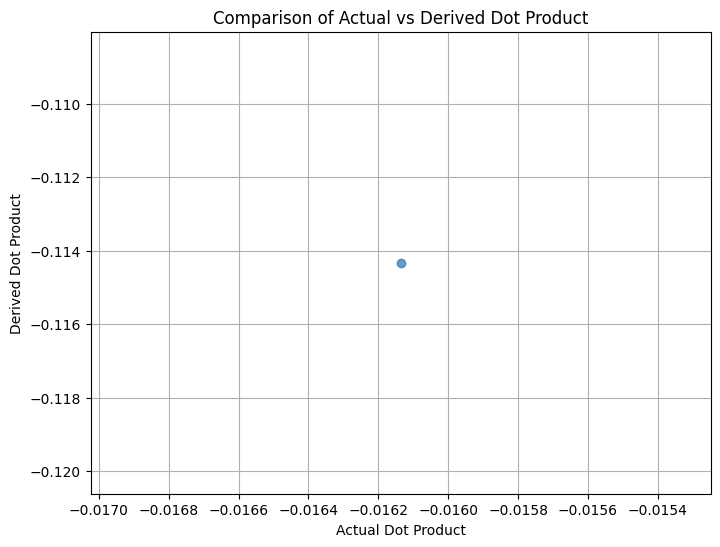

Correlation coefficient: nan


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [14]:

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(actual_dots, derived_dots, alpha=0.7)
# plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Diagonal line for reference
plt.xlabel('Actual Dot Product')
plt.ylabel('Derived Dot Product')
plt.title('Comparison of Actual vs Derived Dot Product')
plt.grid(True)
plt.show()

# Print correlation coefficient
correlation = np.corrcoef(actual_dots, derived_dots)[0, 1]
print(f"Correlation coefficient: {correlation:.6f}")


In [38]:
dotp = LoihiExactDotProduct(np.array([d_dash]), np.array([q_dash]), c, timesteps=t, dbScale=d_s)
transform_queryVectors, transform_dbVectors, monitors =  dotp.run(monitor=True)


transform_dbVectors :
[[ 6.33446252  5.40505692  6.65439118  6.07537512  4.82867022  8.79845136  7.65593036  4.4186447
   4.94745101  7.47876985  8.21590402  7.93155045  3.11659202  5.82182168  7.68595782  5.12522128
   7.72846304  5.1038726   5.96948284  4.40905564  4.42297049  4.03695114  5.14498344  3.86309094
   7.40487248  4.6201584   5.61453264  4.7131625   7.11157417  5.41819883  6.29245473  5.50762576
   7.35457824  4.96401567  2.26128049  5.76054286  5.56371909  4.72582446  4.57998394  5.08261635
   5.25178801  6.63218791  4.72254574  6.39487459  2.20117016  5.53805397  2.71448813  6.30619077
   9.08185322  3.29480538  7.43737231  3.9010164   5.03064512  6.44122255  3.77322928  5.22821486
   3.40580276  6.82382341  4.57132149  4.3118071   4.44438265  3.63307186  4.76397621  1.86880344
   8.06497544  6.22746503  5.12180384  2.51999064  5.95105478  5.58667073  3.47699307  5.12333893
   4.65356382  0.6958682   5.31698207  6.26721294  3.17200131  4.40895654  5.15460697  3.77700924

In [39]:
transform_queryVectors

array([[ 5.53157321,  3.56724684,  4.46017681,  4.19664641,  6.54361327,  4.40203816,  5.93726416,
         8.48476387,  7.2256176 ,  4.35788708,  4.51420164,  5.86503678,  2.28646118,  3.64541668,
         5.92837201,  4.88844642,  8.35829461,  4.05591648,  3.33413616,  3.59902945,  5.12155099,
         4.82692222,  8.85569945,  4.4254478 ,  5.18962541,  6.58760193,  4.91596467,  6.03400512,
         5.76325035,  6.50845344,  2.72584203,  6.45899386,  4.86490875,  5.41326132,  4.44643687,
         7.89313058,  1.64890598,  7.45552352,  3.9538749 ,  7.67399392,  7.15545136,  6.80799061,
         6.49316342,  8.916241  ,  4.09548835,  4.11854732,  3.99281662,  6.65662493,  2.90901275,
         6.80155173,  4.61191864,  3.29896663,  3.28230719,  3.75545666,  2.59414731,  5.96412085,
         6.53302828,  6.71310858,  4.042368  ,  5.61671013,  5.10666566,  6.26301719,  5.84741754,
         5.25000169,  1.96687995,  4.81723377,  5.2847043 ,  3.92731247,  4.64437649,  2.90890525,
         4

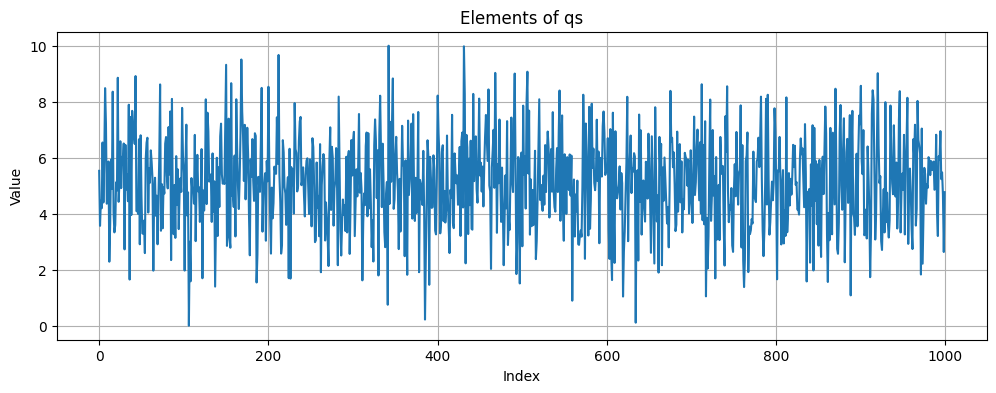

In [40]:
plt.figure(figsize=(12, 4))
plt.plot(transform_queryVectors[0])
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of qs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

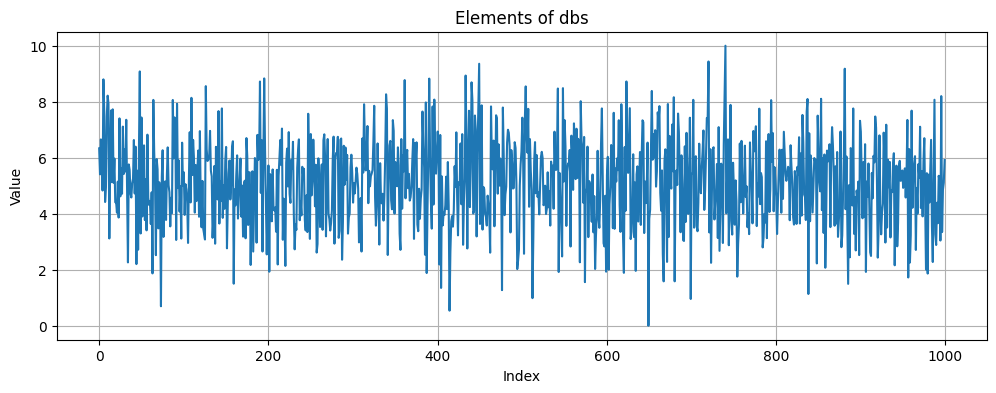

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(transform_dbVectors[0])
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of dbs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [42]:
transform_queryVectors[0][0]

5.531573212713611

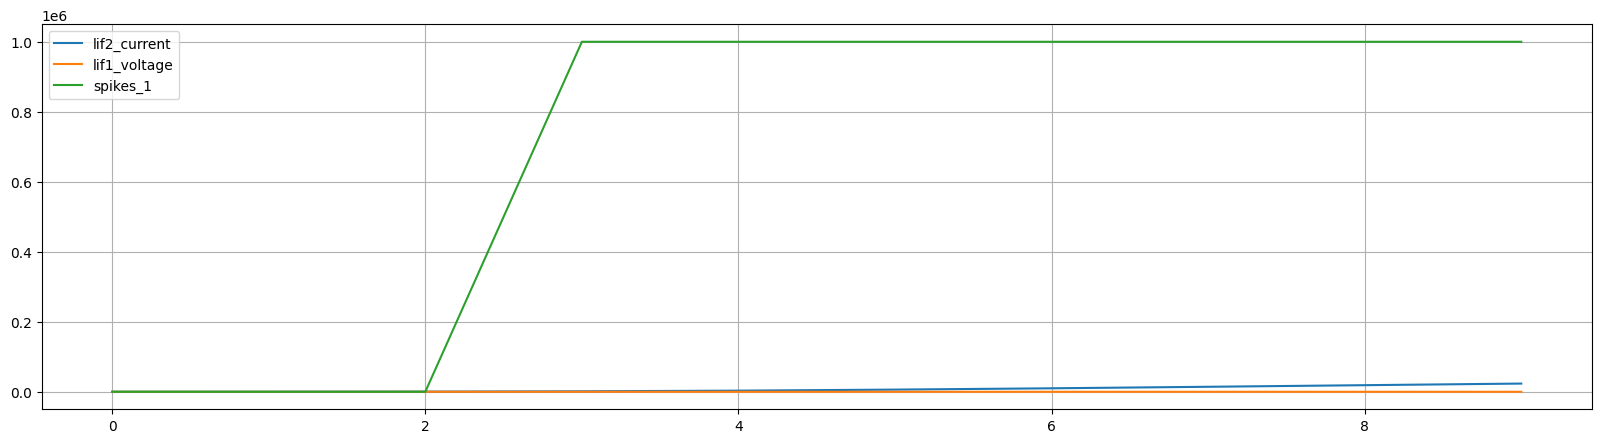

In [43]:
n_id = 0
plt.figure(figsize=(20, 5))
plt.plot(monitors['lif2_current'][:,0], label='lif2_current')
plt.plot(monitors['lif1_voltage'][:,n_id], label='lif1_voltage')
plt.plot(monitors['lif1_spikes'][:,n_id] * (10**6), label='spikes_1')
# plt.axhline(y=-(2**16 - 1)*2**6, color='r', linestyle='--', label='vth_lif_2')  # Changed to horizontal line
plt.grid(True)


plt.legend()
plt.show()

In [44]:
monitors['lif2_current'][:,0][-1] 

23446.0

In [45]:
dotp = LoihiExactDotProduct(np.array([d_dash]), np.array([q_dash]), c, timesteps=t, dbScale=d_s)
dd = dotp.run(customTimesteps=t-1)
print(dd)

transform_dbVectors :
[[ 6.33446252  5.40505692  6.65439118  6.07537512  4.82867022  8.79845136  7.65593036  4.4186447
   4.94745101  7.47876985  8.21590402  7.93155045  3.11659202  5.82182168  7.68595782  5.12522128
   7.72846304  5.1038726   5.96948284  4.40905564  4.42297049  4.03695114  5.14498344  3.86309094
   7.40487248  4.6201584   5.61453264  4.7131625   7.11157417  5.41819883  6.29245473  5.50762576
   7.35457824  4.96401567  2.26128049  5.76054286  5.56371909  4.72582446  4.57998394  5.08261635
   5.25178801  6.63218791  4.72254574  6.39487459  2.20117016  5.53805397  2.71448813  6.30619077
   9.08185322  3.29480538  7.43737231  3.9010164   5.03064512  6.44122255  3.77322928  5.22821486
   3.40580276  6.82382341  4.57132149  4.3118071   4.44438265  3.63307186  4.76397621  1.86880344
   8.06497544  6.22746503  5.12180384  2.51999064  5.95105478  5.58667073  3.47699307  5.12333893
   4.65356382  0.6958682   5.31698207  6.26721294  3.17200131  4.40895654  5.15460697  3.77700924

100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


lif_2.u.get(): [23446.]
[[23446.]]


In [46]:
np.dot(transform_dbVectors[0], transform_queryVectors[0])

26090.231184621254

In [47]:
np.dot(d_dash, q_dash)

26090.231184621254

In [48]:
monitors['lif2_current'][:,0][-1] / np.dot(transform_dbVectors[0], transform_queryVectors[0])

0.898650526861568

In [49]:
0.9907156367106461

0.9907156367106461

In [29]:
snn_loihi_dot_value = snn_dot_loihi(q_dash, d_dash)
snn_dot_value = snn_dot(q_dash, d_dash)

100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


Negative elements count: q_dash=0, d_dash=0


In [30]:
q_dash

array([ 5.53157321,  3.56724684,  4.46017681,  4.19664641,  6.54361327,  4.40203816,  5.93726416,
        8.48476387,  7.2256176 ,  4.35788708,  4.51420164,  5.86503678,  2.28646118,  3.64541668,
        5.92837201,  4.88844642,  8.35829461,  4.05591648,  3.33413616,  3.59902945,  5.12155099,
        4.82692222,  8.85569945,  4.4254478 ,  5.18962541,  6.58760193,  4.91596467,  6.03400512,
        5.76325035,  6.50845344,  2.72584203,  6.45899386,  4.86490875,  5.41326132,  4.44643687,
        7.89313058,  1.64890598,  7.45552352,  3.9538749 ,  7.67399392,  7.15545136,  6.80799061,
        6.49316342,  8.916241  ,  4.09548835,  4.11854732,  3.99281662,  6.65662493,  2.90901275,
        6.80155173,  4.61191864,  3.29896663,  3.28230719,  3.75545666,  2.59414731,  5.96412085,
        6.53302828,  6.71310858,  4.042368  ,  5.61671013,  5.10666566,  6.26301719,  5.84741754,
        5.25000169,  1.96687995,  4.81723377,  5.2847043 ,  3.92731247,  4.64437649,  2.90890525,
        4.55688282, 

In [31]:
d_dash

array([ 6.33446252,  5.40505692,  6.65439118,  6.07537512,  4.82867022,  8.79845136,  7.65593036,
        4.4186447 ,  4.94745101,  7.47876985,  8.21590402,  7.93155045,  3.11659202,  5.82182168,
        7.68595782,  5.12522128,  7.72846304,  5.1038726 ,  5.96948284,  4.40905564,  4.42297049,
        4.03695114,  5.14498344,  3.86309094,  7.40487248,  4.6201584 ,  5.61453264,  4.7131625 ,
        7.11157417,  5.41819883,  6.29245473,  5.50762576,  7.35457824,  4.96401567,  2.26128049,
        5.76054286,  5.56371909,  4.72582446,  4.57998394,  5.08261635,  5.25178801,  6.63218791,
        4.72254574,  6.39487459,  2.20117016,  5.53805397,  2.71448813,  6.30619077,  9.08185322,
        3.29480538,  7.43737231,  3.9010164 ,  5.03064512,  6.44122255,  3.77322928,  5.22821486,
        3.40580276,  6.82382341,  4.57132149,  4.3118071 ,  4.44438265,  3.63307186,  4.76397621,
        1.86880344,  8.06497544,  6.22746503,  5.12180384,  2.51999064,  5.95105478,  5.58667073,
        3.47699307, 

In [32]:
print(snn_loihi_dot_value*64, snn_dot_value)

30461.0 26090.231184621254


## Assume that you have u ε U and normalized (meaning all elements are positive)

In [6]:
from dot_product import LoihiExactDotProduct

D = 1000

In [7]:
np.random.seed(43)

d_original = np.random.randn(D) 
q_original = np.random.randn(D) 

d_min = abs(np.min(d_original))
q_min = abs(np.min(q_original))

d = (d_original + d_min) / np.linalg.norm(d_original + d_min)
q = (q_original + q_min) / np.linalg.norm(q_original + q_min)

In [8]:
s_d = 500
s_q = 500

d_scaled = s_d * d
q_scaled = s_q * q

print(d_scaled[:10])

[16.29076221 10.50572194 13.13544575 12.35933541 19.27127126 12.96422449 17.48554253 24.98805771 21.27980842
 12.83419732]


In [9]:
np.dot(d,q)

0.9070092250969978

In [10]:
np.dot(d_scaled, q_scaled)

226752.30627424945

In [11]:
np.dot(q_original, d_original)


-15.801465710325946

In [12]:
t = 50
d_s = 0

dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=t, dbScale=d_s, func=np.round)
snn_dot = dot_loihi_exact.run(customTimesteps=t-1)[0][0]

100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


In [13]:
print(snn_dot)
# 219244.0 for np.round
# 211751.0 for np.floor

211833.0


In [14]:
snn_dot_exact = snn_dot / (s_d * s_q)
exact_dot     = np.dot(d,q)

In [15]:
snn_dot_exact / exact_dot * 100
# 93.38% for np.floor
# 96.68% for np.round

93.42043901586385

In [16]:
snn_dot * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D


-654.9714905441142

In [17]:
np.dot(d_original, q_original)

-15.801465710325946

### Exp 1 : Random Vectors

In [31]:
np.random.seed(43)
from tqdm import tqdm

snn_dot_exact_lst = []
exact_dot_lst = []
orig_dot_lst = []
orig_dot_derived_lst = []
cpu_scaled_dot_lst = []
snn_scaled_dot_lst = []
snn_scaled_dot_round_lst = []
snn_scaled_dot_floor_T_lst = []

orig_dot_derived_round_lst = []
orig_dot_derived_floor_T_lst = []   


for i in tqdm(range(100)):
    d_original = np.random.randn(D) 
    q_original = np.random.randn(D) 

    d_min = abs(np.min(d_original))
    q_min = abs(np.min(q_original))

    d = (d_original + d_min) / np.linalg.norm(d_original + d_min)
    q = (q_original + q_min) / np.linalg.norm(q_original + q_min)

    s_d = 500
    s_q = 500

    d_scaled = s_d * d
    q_scaled = s_q * q

    t = 50
    dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=t, dbScale=0, func=np.round)
    snn_dot = dot_loihi_exact.run(customTimesteps=t)[0][0]

    dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=t, dbScale=0, func=np.round)
    snn_dot_round = dot_loihi_exact.run(customTimesteps=t-1)[0][0]

    dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=t, dbScale=0, func=np.floor)
    snn_dot_floor_T = dot_loihi_exact.run(customTimesteps=t)[0][0]

    cpu_dot = np.dot(d_scaled, q_scaled)
    snn_dot_exact = snn_dot / (s_d * s_q)
    exact_dot     = np.dot(d,q)
    orig_dot      = np.dot(d_original, q_original)
    orig_dot_derived = snn_dot * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D
    orig_dot_derived_round = snn_dot_round * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D
    orig_dot_derived_floor_T = snn_dot_floor_T * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D

    snn_dot_exact_lst.append(snn_dot_exact)
    exact_dot_lst.append(exact_dot)
    orig_dot_lst.append(orig_dot)
    orig_dot_derived_lst.append(orig_dot_derived)
    orig_dot_derived_round_lst.append(orig_dot_derived_round)
    orig_dot_derived_floor_T_lst.append(orig_dot_derived_floor_T)
    cpu_scaled_dot_lst.append(cpu_dot)
    snn_scaled_dot_lst.append(snn_dot)
    snn_scaled_dot_round_lst.append(snn_dot_round)
    snn_scaled_dot_floor_T_lst.append(snn_dot_floor_T)


100%|██████████| 100/100 [10:04<00:00,  6.04s/it]


In [32]:
# d_scaled[:10]

In [33]:
# v1 = [12.23386971, 12.65831282, 17.17663016,  7.50154863, 21.77764887, 12.14670024,  1.52164889,
#        12.67067483, 22.41007499, 18.0455754 ]
# v2 = [12.23386971, 12.65831282, 17.17663016,  7.50154863, 21.77764887, 12.14670024,  1.52164889,
#        12.67067483, 22.41007499, 18.0455754 ]

# dot_loihi_exact = LoihiExactDotProduct(np.array([v1]), np.array([v2]), 0, timesteps=t, dbScale=0, func=np.floor)
# _, _, monitors = dot_loihi_exact.run(customTimesteps=t, monitor=True)

# dot_loihi_exact = LoihiExactDotProduct(np.array([v1]), np.array([v2]), 0, timesteps=t, dbScale=0, func=np.round)
# snn_dot_round = dot_loihi_exact.run(customTimesteps=t)[0][0]

# cpu_dot = np.dot(v1, v2)


In [34]:
# n_id = 0
# plt.figure(figsize=(20, 5))
# plt.plot(monitors['lif2_current'][:,n_id], label='lif2_current')
# plt.plot(monitors['lif1_voltage'][:,n_id], label='lif1_voltage')
# plt.plot(monitors['lif1_spikes'][:,2] * (10**6), label='spieks_1')
# # plt.axhline(y=-(2**16 - 1)*2**6, color='r', linestyle='--', label='vth_lif_2')  # Changed to horizontal line
# plt.grid(True)


# plt.legend()
# plt.show()


In [35]:
# monitors['lif1_spikes'][:,2]


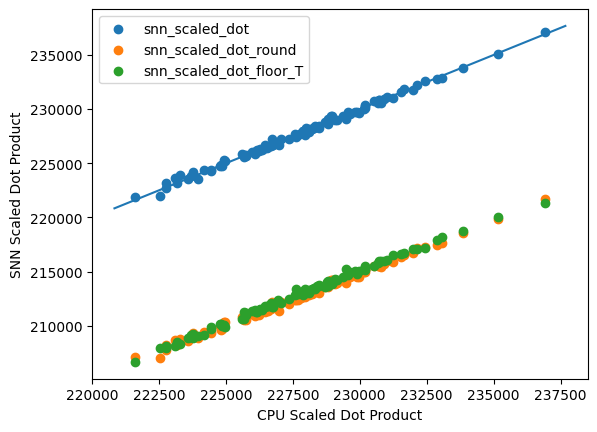

In [36]:
fig, ax = plt.subplots()

plt.scatter(cpu_scaled_dot_lst, snn_scaled_dot_lst, label='snn_scaled_dot')
plt.scatter(cpu_scaled_dot_lst, snn_scaled_dot_round_lst, label='snn_scaled_dot_round')
plt.scatter(cpu_scaled_dot_lst, snn_scaled_dot_floor_T_lst, label='snn_scaled_dot_floor_T')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
# plt.plot([0.89, 0.93], [0.89, 0.93], 'r--')  # Diagonal line for reference
plt.xlabel('CPU Scaled Dot Product')
plt.ylabel('SNN Scaled Dot Product')
plt.legend()
plt.show()

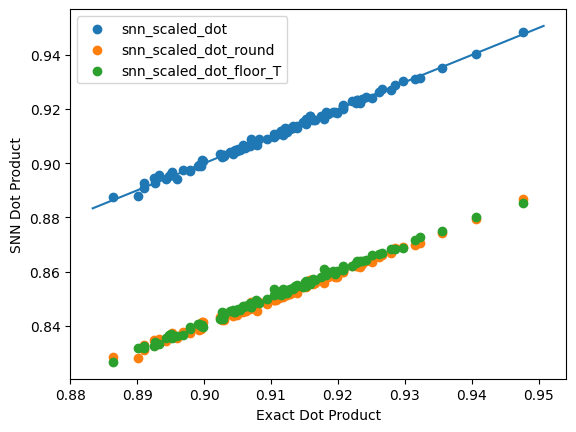

In [37]:
fig, ax = plt.subplots()

plt.scatter(exact_dot_lst, np.array(snn_scaled_dot_lst) / (s_d * s_q), label='snn_scaled_dot')
plt.scatter(exact_dot_lst, np.array(snn_scaled_dot_round_lst) / (s_d * s_q), label='snn_scaled_dot_round')
plt.scatter(exact_dot_lst, np.array(snn_scaled_dot_floor_T_lst) / (s_d * s_q), label='snn_scaled_dot_floor_T')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
# plt.plot([0.89, 0.93], [0.89, 0.93], 'r--')  # Diagonal line for reference
plt.xlabel('Exact Dot Product')
plt.ylabel('SNN Dot Product')
plt.legend()
plt.show()

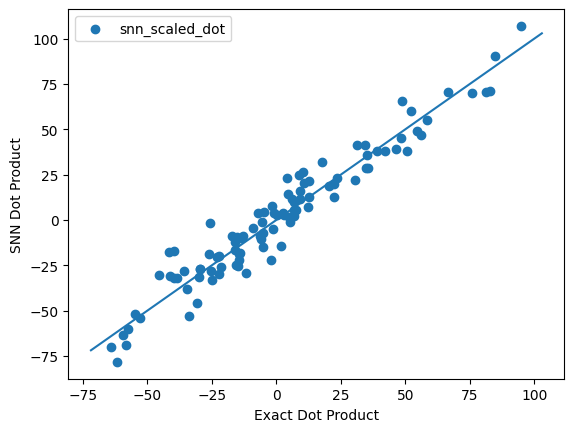

In [40]:
fig, ax = plt.subplots()

plt.scatter(orig_dot_lst, np.array(orig_dot_derived_lst), label='snn_scaled_dot')
# plt.scatter(orig_dot_lst, np.array(orig_dot_derived_round_lst), label='snn_scaled_dot_round')
# plt.scatter(orig_dot_lst, np.array(orig_dot_derived_floor_T_lst), label='snn_scaled_dot_floor_T')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
# plt.plot([0.89, 0.93], [0.89, 0.93], 'r--')  # Diagonal line for reference
plt.xlabel('Exact Dot Product')
plt.ylabel('SNN Dot Product')
plt.legend()
plt.show()

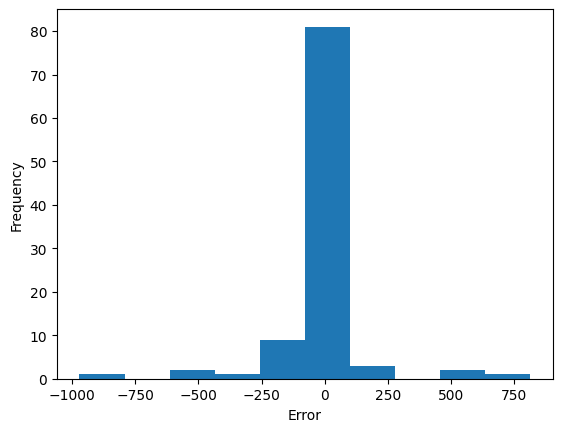

In [39]:
orig_dot_derived_error = [(orig_dot - orig_dot_derived) / orig_dot * 100 for orig_dot, orig_dot_derived in zip(orig_dot_lst, orig_dot_derived_lst)]
plt.hist(orig_dot_derived_error, bins=10)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()




Note: Rounding gives the best results as expected. There was a issue in snn model where I send a extra spike for each number. That's why accuracy was good for t=t-1 simulaitons.

## Different Simulation Times

In [61]:
np.random.seed(43)
from tqdm import tqdm

timesteps_to_test = [25, 30, 35, 40, 45, 50]

# Create dictionaries to store results for different t values
snn_dot_exact_dict = {t: [] for t in timesteps_to_test}
exact_dot_lst = []
orig_dot_lst = []
orig_dot_derived_dict = {t: [] for t in timesteps_to_test}
cpu_scaled_dot_lst = []
snn_scaled_dot_dict = {t: [] for t in timesteps_to_test}

for i in tqdm(range(10)):
    d_original = np.random.randn(D) 
    q_original = np.random.randn(D) 

    d_min = abs(np.min(d_original))
    q_min = abs(np.min(q_original))

    d = (d_original + d_min) / np.linalg.norm(d_original + d_min)
    q = (q_original + q_min) / np.linalg.norm(q_original + q_min)

    s_d = 500
    s_q = 500

    d_scaled = s_d * d
    q_scaled = s_q * q

    # Store these values once per iteration as they don't depend on t
    cpu_dot = np.dot(d_scaled, q_scaled)
    exact_dot = np.dot(d, q)
    orig_dot = np.dot(d_original, q_original)
    
    cpu_scaled_dot_lst.append(cpu_dot)
    exact_dot_lst.append(exact_dot)
    orig_dot_lst.append(orig_dot)
    
    # Run for each timestep value
    for t in timesteps_to_test:
        dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=t, dbScale=0, func=np.round)
        snn_dot = dot_loihi_exact.run(customTimesteps=t)[0][0]

        snn_dot_exact = snn_dot / (s_d * s_q)
        orig_dot_derived = snn_dot * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D

        snn_dot_exact_dict[t].append(snn_dot_exact)
        orig_dot_derived_dict[t].append(orig_dot_derived)
        snn_scaled_dot_dict[t].append(snn_dot)


100%|██████████| 10/10 [02:07<00:00, 12.76s/it]


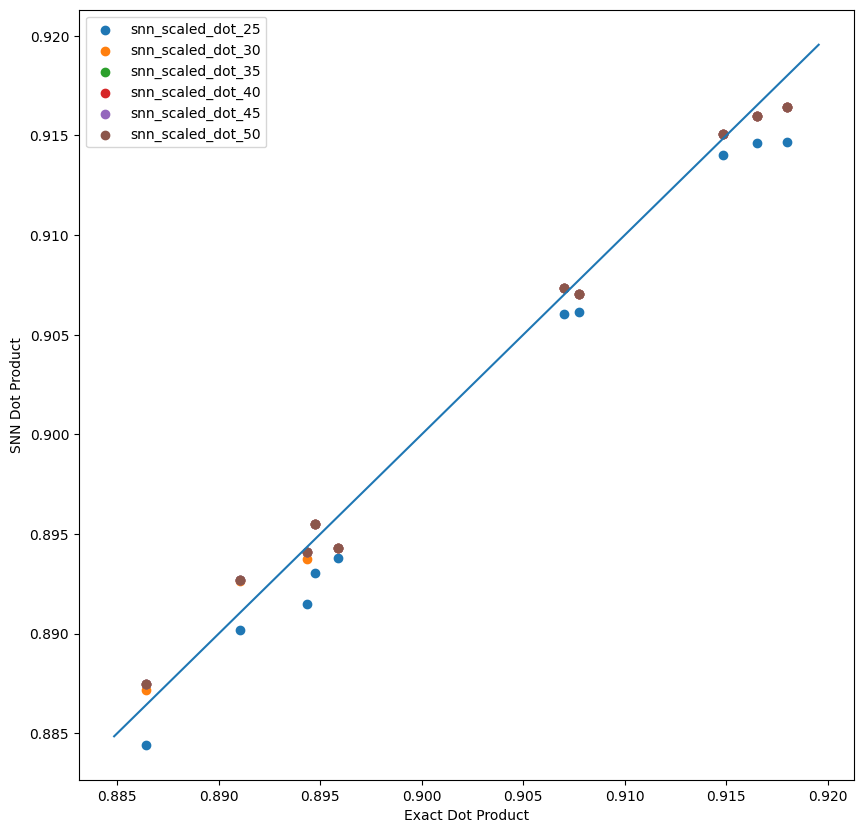

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(exact_dot_lst, np.array(snn_dot_exact_dict[25]), label='snn_scaled_dot_25')
plt.scatter(exact_dot_lst, np.array(snn_dot_exact_dict[30]), label='snn_scaled_dot_30')
plt.scatter(exact_dot_lst, np.array(snn_dot_exact_dict[35]), label='snn_scaled_dot_35')
plt.scatter(exact_dot_lst, np.array(snn_dot_exact_dict[40]), label='snn_scaled_dot_40')
plt.scatter(exact_dot_lst, np.array(snn_dot_exact_dict[45]), label='snn_scaled_dot_45')
plt.scatter(exact_dot_lst, np.array(snn_dot_exact_dict[50]), label='snn_scaled_dot_50')


x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
# plt.plot([0.89, 0.93], [0.89, 0.93], 'r--')  # Diagonal line for reference
plt.xlabel('Exact Dot Product')
plt.ylabel('SNN Dot Product')
plt.legend()
plt.show()

## Different C values

In [74]:
np.random.seed(43)
from tqdm import tqdm

timestep = 30  # Fixed timestep for this experiment
d_min_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # Different d_min values to test
d_min_values = [0.1, 0.5, 1.0, 2.0, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]  # Different d_min values to test

# Create dictionaries to store results for different d_min values
snn_dot_exact_dict = {d_min_val: [] for d_min_val in d_min_values}
exact_dot_lst = {d_min_val: [] for d_min_val in d_min_values}
orig_dot_lst = []
orig_dot_derived_dict = {d_min_val: [] for d_min_val in d_min_values}
cpu_scaled_dot_lst = {d_min_val: [] for d_min_val in d_min_values}
snn_scaled_dot_dict = {d_min_val: [] for d_min_val in d_min_values}

for _ in tqdm(range(10)):
    d_original = np.random.randn(D) 
    q_original = np.random.randn(D) 
    
    orig_dot = np.dot(d_original, q_original)
    orig_dot_lst.append(orig_dot)
    
    # Test different d_min values (with q_min = d_min)
    for d_min_val in d_min_values:
        d_min = d_min_val
        q_min = d_min_val  # Setting q_min equal to d_min as requested
        
        d = (d_original + d_min) / np.linalg.norm(d_original + d_min)
        q = (q_original + q_min) / np.linalg.norm(q_original + q_min)

        s_d = 500
        s_q = 500

        d_scaled = s_d * d
        q_scaled = s_q * q

        # Store these values for each d_min value
        cpu_dot = np.dot(d_scaled, q_scaled)
        exact_dot = np.dot(d, q)
        
        cpu_scaled_dot_lst[d_min_val].append(cpu_dot)
        exact_dot_lst[d_min_val].append(exact_dot)
        
        # Run for the fixed timestep
        dot_loihi_exact = LoihiExactDotProduct(np.array([d_scaled]), np.array([q_scaled]), 0, timesteps=timestep, dbScale=0, func=np.round)
        snn_dot = dot_loihi_exact.run(customTimesteps=timestep)[0][0]

        snn_dot_exact = snn_dot / (s_d * s_q)
        orig_dot_derived = snn_dot * (np.linalg.norm(d_original + d_min) * np.linalg.norm(q_original + q_min)) / (s_d * s_q) - q_min*np.sum(d_original) - d_min*np.sum(q_original) - q_min*d_min*D

        snn_dot_exact_dict[d_min_val].append(snn_dot_exact)
        orig_dot_derived_dict[d_min_val].append(orig_dot_derived)
        snn_scaled_dot_dict[d_min_val].append(snn_dot)


100%|██████████| 10/10 [04:21<00:00, 26.19s/it]


In [67]:
exact_dot_lst[0.1]

[-0.0017200950401628575,
 -0.014584246533678933,
 0.05156999683602474,
 -0.026096355302698923,
 -0.041170640280683665,
 0.012926187185236719,
 -0.020421067138714596,
 -0.05014907991566646,
 -0.03319930107510465,
 -0.0011990118733821184]

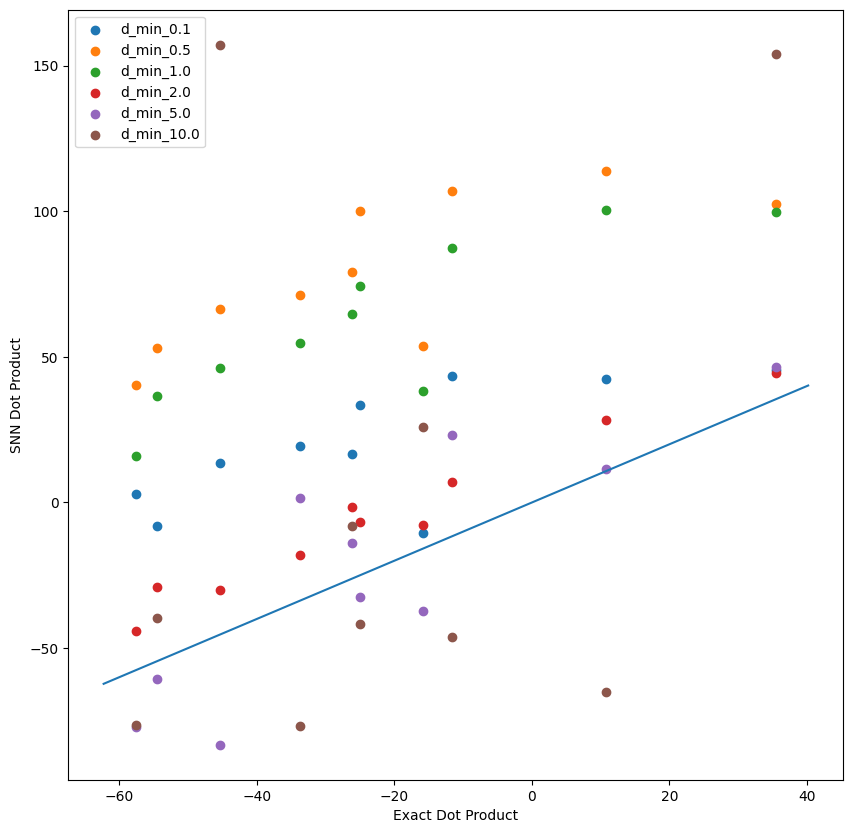

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(orig_dot_lst, np.array(orig_dot_derived_dict[0.1]), label='d_min_0.1')
plt.scatter(orig_dot_lst, np.array(orig_dot_derived_dict[0.5]), label='d_min_0.5')
plt.scatter(orig_dot_lst, np.array(orig_dot_derived_dict[1.0]), label='d_min_1.0')
plt.scatter(orig_dot_lst, np.array(orig_dot_derived_dict[2.0]), label='d_min_2.0')
plt.scatter(orig_dot_lst, np.array(orig_dot_derived_dict[5.0]), label='d_min_5.0')
plt.scatter(orig_dot_lst, np.array(orig_dot_derived_dict[10.0]), label='d_min_10.0')


x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
# plt.plot([0.89, 0.93], [0.89, 0.93], 'r--')  # Diagonal line for reference
plt.xlabel('Exact Dot Product')
plt.ylabel('SNN Dot Product')
plt.legend()
plt.show()

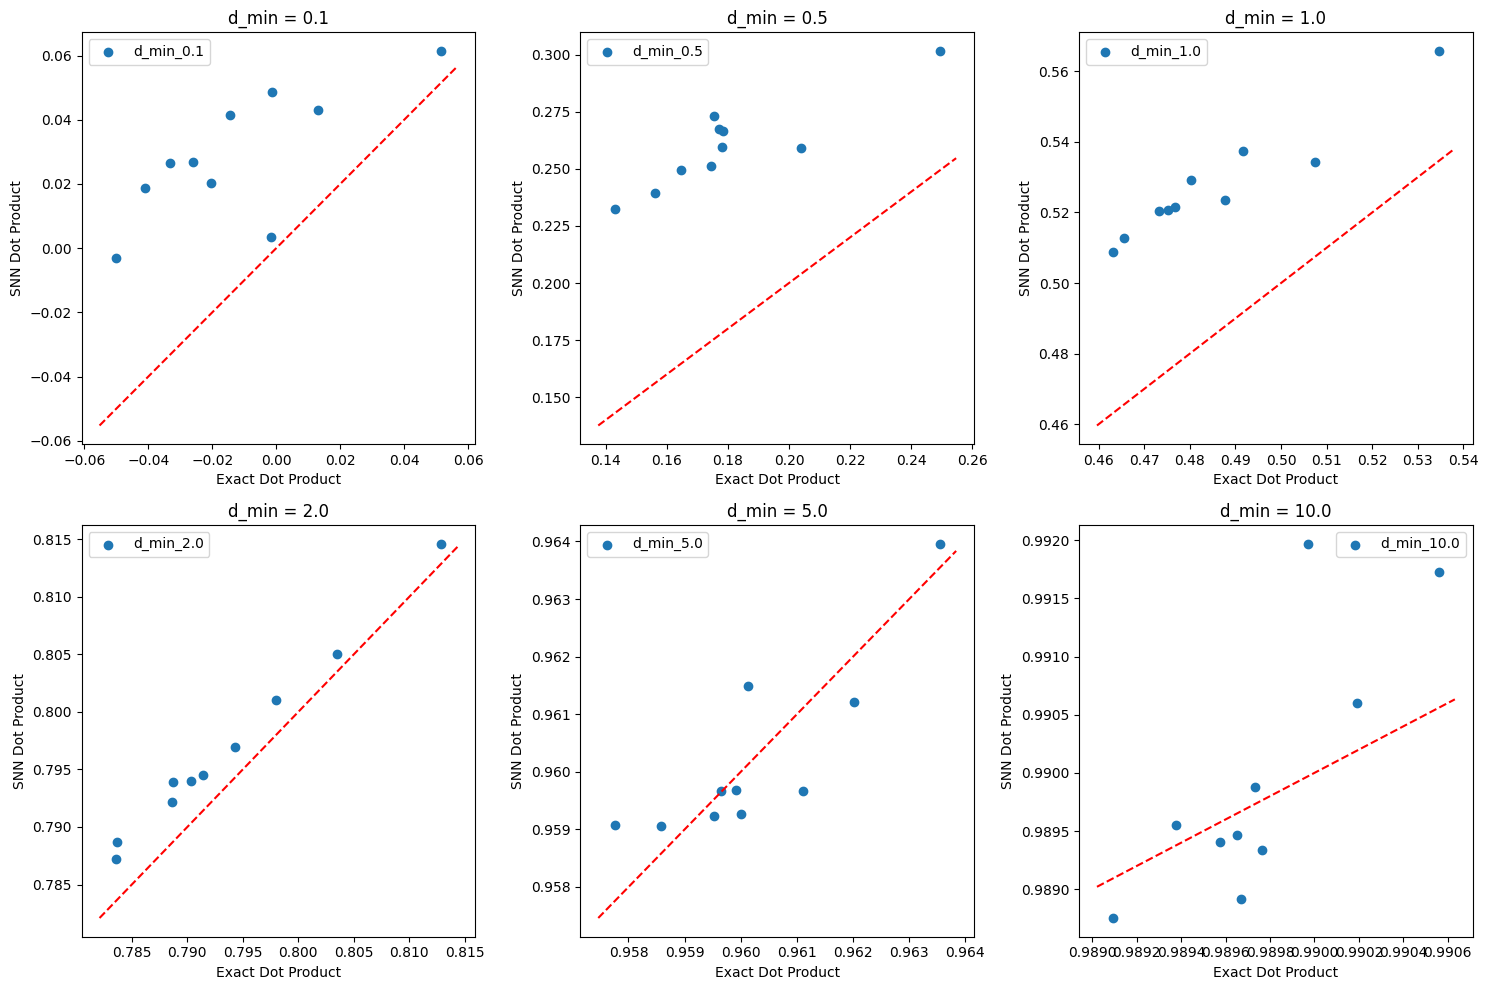

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# d_min_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

for i, d_min_val in enumerate(d_min_values):
    ax = axes[i]
    ax.scatter(exact_dot_lst[d_min_val], np.array(snn_dot_exact_dict[d_min_val]), label=f'd_min_{d_min_val}')
    
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, 'r--')
    
    ax.set_xlabel('Exact Dot Product')
    ax.set_ylabel('SNN Dot Product')
    ax.set_title(f'd_min = {d_min_val}')
    ax.legend()

plt.tight_layout()
plt.show()

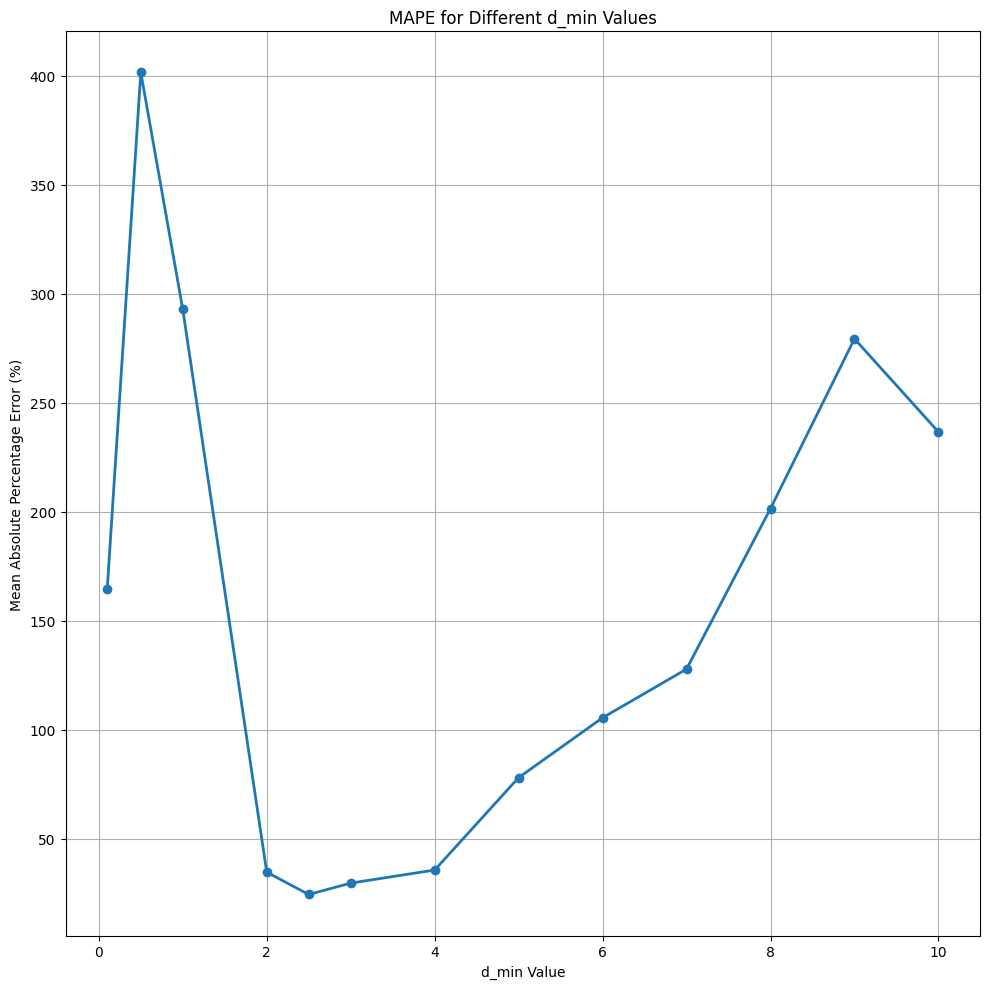

MAPE values for each d_min:
d_min 0.1: 164.47%
d_min 0.5: 401.55%
d_min 1.0: 292.82%
d_min 2.0: 34.68%
d_min 2.5: 24.47%
d_min 3.0: 29.69%
d_min 4.0: 35.69%
d_min 5.0: 78.09%
d_min 6.0: 105.54%
d_min 7.0: 127.86%
d_min 8.0: 201.51%
d_min 9.0: 279.36%
d_min 10.0: 236.65%


In [76]:
# Calculate MAPE for each d_min value
mape_values = {}
d_min_list = np.copy(d_min_values)
for d_min in d_min_list:
    # Calculate Mean Absolute Percentage Error
    actual = np.array(orig_dot_lst)
    predicted = np.array(orig_dot_derived_dict[d_min])
    # Avoid division by zero by adding small epsilon
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100
    mape_values[d_min] = mape

# Plot MAPE values as a line chart with linear x-axis
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(d_min_list, [mape_values[d] for d in d_min_list], marker='o', linestyle='-', linewidth=2)
plt.xlabel('d_min Value')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.title('MAPE for Different d_min Values')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print MAPE values
print("MAPE values for each d_min:")
for d_min, mape in mape_values.items():
    print(f"d_min {d_min}: {mape:.2f}%")

In [77]:
d_min_list

array([ 0.1,  0.5,  1. ,  2. ,  2.5,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ])

In [79]:
orig_dot_derived_dict

{0.1: [-6.9566585613213805,
  32.978013373817056,
  43.45465330953719,
  17.76115776515754,
  2.7092326648335625,
  38.073637875430165,
  16.352972256842413,
  -4.7521233792793165,
  16.60812781030711,
  38.97009443977891],
 0.5: [51.42987660725851,
  93.79616312284605,
  92.52548850964706,
  61.373119980279,
  30.113431340708075,
  101.23188066022874,
  70.95862150629392,
  49.141122547463624,
  62.2069332753984,
  91.46638719793083],
 1.0: [29.090059094361322,
  60.72669824329796,
  82.76000445201907,
  37.40191497531214,
  -2.553212001019574,
  79.64514239982236,
  45.977593970924545,
  25.06432415251311,
  35.439449078276766,
  61.136053565862994],
 2.0: [-12.979394711683199,
  -12.301092927035825,
  34.47552790201826,
  -25.576081610873644,
  -53.43130540539869,
  16.069515273402885,
  -13.766352919016299,
  -32.84576501192214,
  -34.3884937711191,
  -1.9534370589008176],
 2.5: [-14.315270147625597,
  -23.04676762469353,
  23.033983836537118,
  -29.93622315642915,
  -62.0052197706